In [1]:
from qiskit import *
from qiskit.quantum_info import Operator
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import numpy as np


from IPython.display import Image

# Grover's Algorithm

All images were stolen from the Qiskit textbook (link in your course's README page). The chapter on Grover's algorithm might even help with this exercise! 

In this notebook, we will use Qiskit to implement Grover's algorithm. As you learned in class, Grover's algorithm yields a quadratic speedup in unstructured search problems. Concretely, suppose we were given a list of $N$ items, represented as boxes below:

In [2]:
Image(url="grover_list.png", width=800, height=400)

One item---the ``winner'' $\omega$ coloured purple above---is the marked item we're searching for. Classically, finding $\omega$ would require that we check $O(N)$ boxes. On a quantum computer, the same task can be accomplished in $O(\sqrt{N})$ steps using Grover's amplitude amplification trick. At a high level, the algorithm involves three steps: state preparation, application of the oracle, and application of the diffuser:

In [3]:
Image(url="grover_circuit_high_level.png", width=1000, height=400)

The first step, state preparation, is a step you've seen before: We create a uniform superposition state $\vert s\rangle=H^{\otimes n}\ket{0}$ by applying Hadamards to all $n$ qubits initialized in $\vert 0\rangle$. Geometrically, we can visualize this state as a vector in a two-dimensional plane spanned by $\vert\omega\rangle$, representing the marked element $\omega$, and the state $\ket{s'}$ obtained by subtracting $\vert \omega\rangle$ from $\vert s\rangle$ and renormalizing. Concretely, we have 

$$\vert s\rangle=\sin{\theta}\vert \omega\rangle + \cos{\theta}\vert s'\rangle,$$

where the angle $\theta$ is given by

$$\theta=\mathrm{arcsin}\langle s\vert \omega\rangle=\mathrm{arcsin}(1/\sqrt{N}).$$

Here, $N=2^n$ is the dimension of the $n$-qubit Hilbert space.

In [4]:
Image(url="grover_step1.jpg", width=1000, height=400)

The oracle $U_f$ imparts a $\pi$ phase shift (minus sign) to the marked element $\vert \omega\rangle$, leaving all other states unchanged. This corresponds to a reflection of $\vert s\rangle$ about $\vert s'\rangle$. The negative amplitude of $\vert \omega\rangle$ also implies that the average amplitude (indicated by a dashed line below) has been reduced from its original value of $1/\sqrt{N}$. 

In [5]:
Image(url="grover_step2.jpg", width=1000, height=400)

Finally, we apply the diffuser $U_s=2\vert s\rangle\langle s \vert-1$, which implements an additional reflection about the state $\vert s\rangle$. The net effect of the oracle and diffuser is to rotate the initial state $\vert s\rangle$ towards the marked element $\vert \omega\rangle$, effectively amplifying the amplitude of $\vert \omega\rangle$ relative to all other unmarked states.

In [6]:
Image(url="grover_step3.jpg", width=1000, height=400)

For $k$ marked elements, the optimal number of repetitions is given by $$r=\left\lfloor\frac{\pi}{4}\sqrt{\frac{N}{k}}\right\rfloor,$$

where $\lfloor \rfloor$ is the floor function. Note the $\sqrt{N}$ scaling.

Now, let's implement both the oracle and diffuser in Qiskit. The function ```oracle``` below takes two arguments, ```n``` and ```marked_items```. The first is the number of qubits in the circuit, while the second is a list containing the indices of marked elements. To define the oracle, create an identity matrix of dimension $2^n$, and flip the signs of all diagonal elements contained in the list ```marked_items```.

In [7]:
def oracle(n, marked_items):
    
    # Create an n-qubit quantum circuit
    qc = QuantumCircuit(n, name='Oracle')

    ### YOUR CODE GOES HERE - START
    
    oracle = np.identity(2**n)
    for index in marked_items:
        oracle[index, index] = -1
        
    ### YOUR CODE GOES HERE - END

    # This converts your matrix into an operator and appends it to the circuit. Do not alter this line.
    qc.unitary(Operator(oracle), range(n))
    
    return qc

The purpose of the diffuser is to reflect all amplitudes about the average amplitude. One way to do this (see Qiskit textbook) is to apply Hadamards to all qubits, followed by the oracle with only the state $\vert0\rangle^{\otimes n}$ as the marked element, i.e. ```marked_items=[0]```. Following the application of the oracle, Hadamards are once again applied to all qubits. A helpful function for applying a pre-defined operator is ```qc.append(operator, indices)```, where ```operator``` is the operator and ```indices``` is a list of qubits to which the operator should be applied. For instance, let's say we've defined a three-qubit operator called ```myunitary``` that we want to apply to qubits 0, 3, and 4. This can be done with the line ```qc.append(myunitary, [0,3,4])```.

In [11]:
def diffuser(n, name='Diffuser'):
    
    # Create an n-qubit quantum circuit
    qc = QuantumCircuit(n, name='Diffuser')
    
    ### YOUR CODE GOES HERE - START
    qc.h(range(n))
    qc.append(oracle(n, [0]), range(n))
    qc.h(range(n))
     
    ### YOUR CODE GOES HERE - END
    
    return qc

Next, let's define a function that calculates $r$, the optimal number of repetitions. Your job is to code the formula for $r$ given above. The function ```np.floor``` may be helpful.

In [12]:
def optimal_r(n, marked_items):
    k = len(marked_items)

    ### YOUR CODE GOES HERE - START
    
    r = int(np.floor(np.pi/4*np.sqrt(2**n/k)))

    ### YOUR CODE GOES HERE - END
    
    return r

We can finally put all of the pieces together. Let's use the functions you wrote above to run Grover's algorithm for six qubits ($n=6$) and the marked items 10 and 32. Note that these marked items correspond to the bitstrings 001010 and 100000, respectively. You don't need to modify the code below -- just run it.

In [13]:
def full_algorithm(n, marked_items):
    
    qc = QuantumCircuit(n, n)
    r = optimal_r(n, marked_items)
    print('The optimal number of repetitions is r =', r)
    
    # Step 1: State preparation
    qc.h(range(n))
    
    # Steps 2 and 3, repeated r times: 
    for _ in range(r):
        qc.append(oracle(n, marked_items), range(n))
        qc.append(diffuser(n), range(n))
        
    # Measure all qubits
    qc.measure(range(n), range(n))
  
    return qc

grover = full_algorithm(6, [10, 32])
grover.draw()

The optimal number of repetitions is r = 4


┌───┐┌─────────┐┌───────────┐┌─────────┐┌───────────┐┌─────────┐»
q_0: ┤ H ├┤0        ├┤0          ├┤0        ├┤0          ├┤0        ├»
     ├───┤│         ││           ││         ││           ││         │»
q_1: ┤ H ├┤1        ├┤1          ├┤1        ├┤1          ├┤1        ├»
     ├───┤│         ││           ││         ││           ││         │»
q_2: ┤ H ├┤2        ├┤2          ├┤2        ├┤2          ├┤2        ├»
     ├───┤│  Oracle ││  Diffuser ││  Oracle ││  Diffuser ││  Oracle │»
q_3: ┤ H ├┤3        ├┤3          ├┤3        ├┤3          ├┤3        ├»
     ├───┤│         ││           ││         ││           ││         │»
q_4: ┤ H ├┤4        ├┤4          ├┤4        ├┤4          ├┤4        ├»
     ├───┤│         ││           ││         ││           ││         │»
q_5: ┤ H ├┤5        ├┤5          ├┤5        ├┤5          ├┤5        ├»
     └───┘└─────────┘└───────────┘└─────────┘└───────────┘└─────────┘»
c: 6/════════════════════════════════════════════════════════════════»
                                                                     »
«     ┌───────────┐┌─────────┐┌───────────┐┌─┐               
«q_0: ┤0          ├┤0        ├┤0          ├┤M├───────────────
«     │           ││         ││           │└╥┘┌─┐            
«q_1: ┤1          ├┤1        ├┤1          ├─╫─┤M├────────────
«     │           ││         ││           │ ║ └╥┘┌─┐         
«q_2: ┤2          ├┤2        ├┤2          ├─╫──╫─┤M├─────────
«     │  Diffuser ││  Oracle ││  Diffuser │ ║  ║ └╥┘┌─┐      
«q_3: ┤3          ├┤3        ├┤3          ├─╫──╫──╫─┤M├──────
«     │           ││         ││           │ ║  ║  ║ └╥┘┌─┐   
«q_4: ┤4          ├┤4        ├┤4          ├─╫──╫──╫──╫─┤M├───
«     │           ││         ││           │ ║  ║  ║  ║ └╥┘┌─┐
«q_5: ┤5          ├┤5        ├┤5          ├─╫──╫──╫──╫──╫─┤M├
«     └───────────┘└─────────┘└───────────┘ ║  ║  ║  ║  ║ └╥┘
«c: 6/══════════════════════════════════════╩══╩══╩══╩══╩══╩═
«                                           0  1  2  3  4  5

Let's simulate the outcomes using the code below. If you've done everything correctly, most of the counts should be clustered about the two marked elements, ```001010``` and ```100000```.

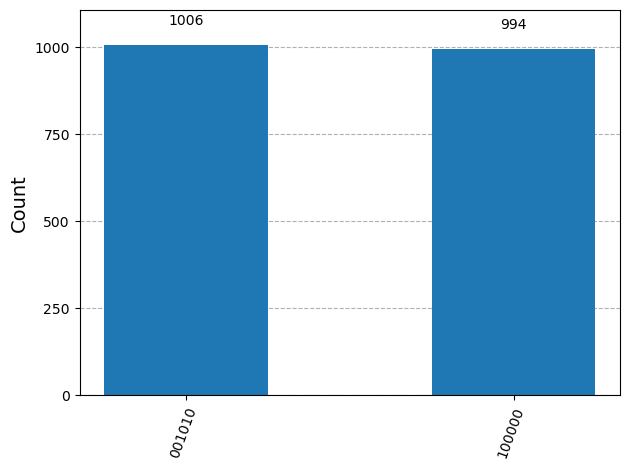

In [14]:
backend = AerSimulator()

circuit = transpile(grover, backend)
job = backend.run(circuit, shots=2000)
counts = job.result().get_counts()
plot_histogram(counts)